Imports.

In [1436]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

Constants about the interest rate models.

In [1437]:
BLOCKS_PER_YEAR = 1_000

JUMP_IRM_BASE_BORROW_RATE = 0 # annualized borrow rate at zero utilization
JUMP_IRM_BORROW_RATE_MULTIPLIER = 0.05 # annualized borrow rate at full utilization (excluding kink)
JUMP_IRM_KINK_UTILIZATION_RATE = 0.8 # utilization rate at which slope of borrow rate increases
JUMP_IRM_KINK_BORROW_RATE_MULTIPLIER = 1 # additional borrow rate multiplier after the kink

# we use the "kink" from the jump IRM in the PID controller too, this allows the model to instantly respond to borrow saturation
# this also serves as the "P" in the PID controller
PID_IRM_TARGET_UTILIZATION_RATE = 0.8 # what utilization rate the PID controller is trying to achieve
PID_IRM_KINK_UTILIZATION_RATE = 0
PID_IRM_KINK_BORROW_RATE_MULTIPLIER = 0.1
PID_IRM_INTEGRAL_GAIN = 0.02 # how quickly the PID IRM will decrease borrow interest rates when utilization rate is below target and vice versa
PID_IRM_DERIVATIVE_GAIN = 100 # how aggressively the PID IRM inversely corrects interest rates to avoid overshooting

RESERVE_FACTOR = 0.1 # percent of interest paid by borrowers reserved by the protocol (same for both IRMs)

State for the interest rate models.

In [1438]:
interest_rate_model_in_use = 'jump'

block_number = 0

lent_currency = 0
borrowed_currency = 0

pid_derivative_signal = 0
pid_integral_accumulator = 0
pid_last_evaluated_block = 0
pid_last_evaluated_utilization_rate = 0

Getters for the Jump IRM.

In [1439]:
def get_borrow_interest_rate_jump_irm():
  utilization_rate = get_utilization_rate()

  if utilization_rate == 0:
    return 0

  normal_borrow_rate = utilization_rate * JUMP_IRM_BORROW_RATE_MULTIPLIER + JUMP_IRM_BASE_BORROW_RATE

  if utilization_rate < JUMP_IRM_KINK_UTILIZATION_RATE:
    return normal_borrow_rate
  else:
    excess_utilization = utilization_rate - JUMP_IRM_KINK_UTILIZATION_RATE
    return normal_borrow_rate + (excess_utilization * JUMP_IRM_KINK_BORROW_RATE_MULTIPLIER)

def get_supply_interest_rate_jump_irm():
  if borrowed_currency == 0:
    return 0.05 # "unstick model at simulation start"
  
  return get_borrow_interest_rate_jump_irm() * (1 - RESERVE_FACTOR) * get_utilization_rate()

Getters for the PID IRM.

In [1440]:
def get_proportional_signal_pid_irm():
  utilization_rate = get_utilization_rate()

  proportional_signal = 0
  if utilization_rate > PID_IRM_KINK_UTILIZATION_RATE:
    excess_utilization = utilization_rate - PID_IRM_KINK_UTILIZATION_RATE
    proportional_signal = excess_utilization * PID_IRM_KINK_BORROW_RATE_MULTIPLIER

  return proportional_signal

def get_borrow_interest_rate_pid_irm():
  global pid_derivative_signal, pid_integral_accumulator, pid_last_evaluated_block, pid_last_evaluated_utilization_rate, block_number

  utilization_rate = get_utilization_rate()

  if utilization_rate == 0:
    return 0

  proportional_signal = get_proportional_signal_pid_irm()

  pid_integral_accumulator += (utilization_rate - PID_IRM_TARGET_UTILIZATION_RATE) / BLOCKS_PER_YEAR
  integral_signal = pid_integral_accumulator * PID_IRM_INTEGRAL_GAIN

  if pid_last_evaluated_block != block_number:
    block_difference = block_number - pid_last_evaluated_block
    pid_derivative_signal = (utilization_rate - pid_last_evaluated_utilization_rate) / (BLOCKS_PER_YEAR / block_difference) * PID_IRM_DERIVATIVE_GAIN

  pid_last_evaluated_block = block_number
  pid_last_evaluated_utilization_rate = utilization_rate

  return max(0, proportional_signal + integral_signal + pid_derivative_signal)

def get_supply_interest_rate_pid_irm():
  if borrowed_currency == 0:
    return 0.05 # "unstick model at simulation start"
  
  return get_borrow_interest_rate_pid_irm() * (1 - RESERVE_FACTOR) * get_utilization_rate()

Getters for both IRMs.

In [1441]:
def get_utilization_rate():
  if lent_currency == 0:
    return 0

  return borrowed_currency / lent_currency

def get_liquidity():
  return lent_currency - borrowed_currency

def get_borrow_interest_rate():
  if interest_rate_model_in_use == 'jump':
    return get_borrow_interest_rate_jump_irm()
  if interest_rate_model_in_use == 'pid':
    return get_borrow_interest_rate_pid_irm()

def get_supply_interest_rate():
  if interest_rate_model_in_use == 'jump':
    return get_supply_interest_rate_jump_irm()
  if interest_rate_model_in_use == 'pid':
    return get_supply_interest_rate_pid_irm()

Definition for the commercial trader agent. The purpose of this agent is to simulate a trader who has an opinion on the fair market interest rate to lend or borrow, and will open positions when the market-offered interest rate is favorable to them.

The agent's equilibrium rate (their "opinion" on what the fair market interest rate should be) is given by a normal random walk with a drift towards the market-offered borrow rate at each timestep. This ensures there is a dispersion of opinions around some volatile consensus interest rate.

Each agent's bankroll (total borrowing or lending power) is drawn from a Pareto distribution. The percentage of their bankroll which they borrow or lend is based on tanh biased by their internal equilibrium rate.

In [1442]:
NUM_COMMERCIAL_TRADERS = 100 # the number of commercial traders in the simulation
COMMERCIAL_TRADER_INITIAL_EQUILIBRIUM_RATE = 0.05 # what each commercial trader's equilibrium rate starts at
COMMERCIAL_TRADER_PARETO_SHAPE = 3 # higher = more fat-tailed
COMMERCIAL_TRADER_MODE_BANKROLL = 10_000 # the mode bankroll of a commercial trader, from a Pareto distribution
COMMERCIAL_TRADER_INTERNAL_VOLATILITY = 100 # annualized volatility of the equilibrium rate
COMMERCIAL_TRADER_REGULARIZATION_RATE = 0.9 # how much their equlibrium rate "decays" to the market-offered borrow rate per year
COMMERCIAL_TRADER_RISK_AVERSION = 25 # scaling factor of the tanh (trader requires a larger buffer in their favor to take a position)

class CommercialTrader:
  def __init__(self):
    self.bankroll = (np.random.pareto(COMMERCIAL_TRADER_PARETO_SHAPE)) * COMMERCIAL_TRADER_MODE_BANKROLL
    self.equilibrium_rate = COMMERCIAL_TRADER_INITIAL_EQUILIBRIUM_RATE
    self.position = 0 # positive means supplying, negative means borrowing

  def _get_target_position(self):
    borrow_interest_rate = get_borrow_interest_rate()
    supply_interest_rate = get_supply_interest_rate()

    borrow_advantage = self.equilibrium_rate - borrow_interest_rate
    supply_advantage = supply_interest_rate - self.equilibrium_rate

    if borrow_advantage >= supply_advantage and borrow_advantage > 0:
      return self.bankroll * math.tanh((borrow_interest_rate - self.equilibrium_rate) * COMMERCIAL_TRADER_RISK_AVERSION)
    elif supply_advantage >= borrow_advantage and supply_advantage > 0:
      return self.bankroll * math.tanh((supply_interest_rate - self.equilibrium_rate) * COMMERCIAL_TRADER_RISK_AVERSION)
    else:
      return 0

  def _supply(self, supply_amount):
    global lent_currency

    self.position += supply_amount
    lent_currency += supply_amount

  def _withdraw(self, withdrawal_amount):
    global lent_currency

    actual_withdrawal_amount = min(withdrawal_amount, get_liquidity())
    self.position -= actual_withdrawal_amount
    lent_currency -= actual_withdrawal_amount

    return actual_withdrawal_amount == withdrawal_amount

  def _borrow(self, borrow_amount):
    global borrowed_currency

    actual_borrow_amount = min(borrow_amount, get_liquidity())
    self.position -= actual_borrow_amount
    borrowed_currency += actual_borrow_amount

    return actual_borrow_amount == borrow_amount

  def _repay(self, repay_amount):
    global borrowed_currency

    self.position += repay_amount
    borrowed_currency -= repay_amount

  def step(self):
    equilibrium_rate_displacement = np.random.normal(scale=COMMERCIAL_TRADER_INTERNAL_VOLATILITY) / BLOCKS_PER_YEAR
    self.equilibrium_rate *= (1 + equilibrium_rate_displacement)
    self.equilibrium_rate -= (self.equilibrium_rate - get_borrow_interest_rate()) * COMMERCIAL_TRADER_REGULARIZATION_RATE / BLOCKS_PER_YEAR

    target_position = self._get_target_position()

    if self.position >= 0 and target_position >= 0:
      position_difference = target_position - self.position
      if position_difference > 0:
        self._supply(position_difference)
      else:
        self._withdraw(-position_difference)
    elif self.position < 0 and target_position < 0:
      position_difference = target_position - self.position
      if position_difference < 0:
        self._borrow(-position_difference)
      else:
        self._repay(position_difference)
    elif self.position >= 0 and target_position < 0:
      if self._withdraw(self.position):
        self._borrow(-target_position)
    elif self.position < 0 and target_position >= 0:
      if self._repay(-self.position):
        self._supply(target_position)

Definition for the noise trader agent. This agent is meant to simulate a less-informed trader, or a large trader who is trying to get in and out of positions quickly without slippage.

Like the commercial trader, this trader's bankroll is sampled from a Pareto distribution. Each timestep, the agent has a chance to sample a new target position from a uniform distribution between -1 and 1 times its bankroll.

In [1443]:
NUM_NOISE_TRADERS = 50 # the number of noise traders in the simulation
NOISE_TRADER_PARETO_SHAPE = 3 # higher = more fat-tailed
NOISE_TRADER_MODE_BANKROLL = 25_000 # the mode bankroll of a noise trader, from a Pareto distribution
NOISE_TRADER_RESAMPLING_RATE = 4 # average number of times per year a noise trader changes their position

class NoiseTrader:
  def __init__(self):
    self.bankroll = np.random.pareto(NOISE_TRADER_PARETO_SHAPE) * NOISE_TRADER_MODE_BANKROLL
    self.position = 0 # positive means supplying, negative means borrowing
    self.target_position = 0

  def _supply(self, supply_amount):
    global lent_currency

    self.position += supply_amount
    lent_currency += supply_amount

  def _withdraw(self, withdrawal_amount):
    global lent_currency

    actual_withdrawal_amount = min(withdrawal_amount, get_liquidity())
    self.position -= actual_withdrawal_amount
    lent_currency -= actual_withdrawal_amount

    return actual_withdrawal_amount == withdrawal_amount

  def _borrow(self, borrow_amount):
    global borrowed_currency

    actual_borrow_amount = min(borrow_amount, get_liquidity())
    self.position -= actual_borrow_amount
    borrowed_currency += actual_borrow_amount

    return actual_borrow_amount == borrow_amount

  def _repay(self, repay_amount):
    global borrowed_currency

    self.position += repay_amount
    borrowed_currency -= repay_amount

  def step(self):
    chance_to_resample = NOISE_TRADER_RESAMPLING_RATE / BLOCKS_PER_YEAR
    if random.random() < chance_to_resample:
      self.target_position = self.bankroll * np.random.uniform(low=-1.0, high=1.0)

    target_position = self.target_position

    if self.position >= 0 and target_position >= 0:
      position_difference = target_position - self.position
      if position_difference > 0:
        self._supply(position_difference)
      else:
        self._withdraw(-position_difference)
    elif self.position < 0 and target_position < 0:
      position_difference = target_position - self.position
      if position_difference < 0:
        self._borrow(-position_difference)
      else:
        self._repay(position_difference)
    elif self.position >= 0 and target_position < 0:
      if self._withdraw(self.position):
        self._borrow(-target_position)
    elif self.position < 0 and target_position >= 0:
      if self._repay(-self.position):
        self._supply(target_position)

Initialize agents and run the actual simulation for the jump IRM.

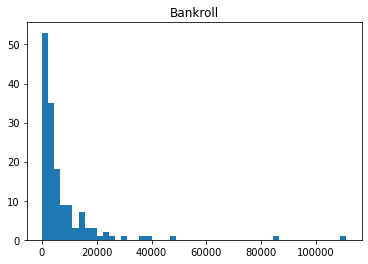

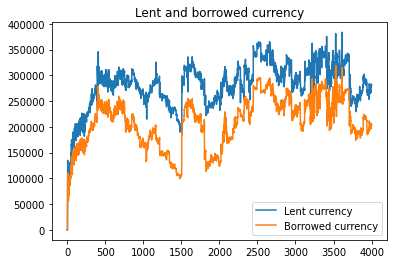

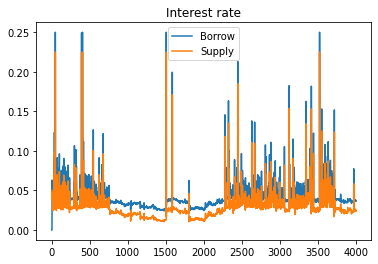

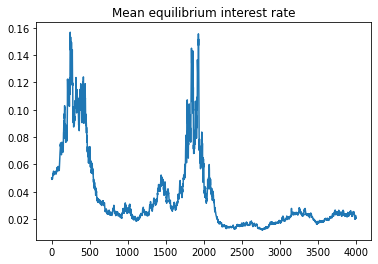

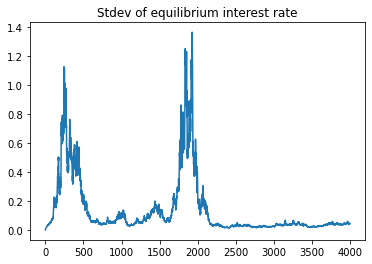

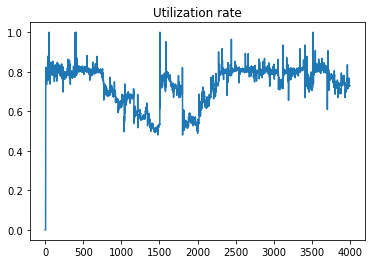

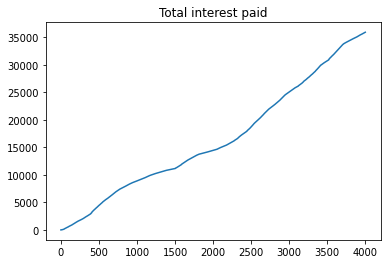

In [1444]:
SIMULATION_LENGTH_YEARS = 4

agents = []

for i in range(NUM_COMMERCIAL_TRADERS):
  agents.append(CommercialTrader())

for i in range(NUM_NOISE_TRADERS):
  agents.append(NoiseTrader())

plt.hist([agent.bankroll for agent in agents], bins=50)
plt.title('Bankroll')
plt.show()

lent_currency_history = []
borrowed_currency_history = []
borrow_interest_rate_history = []
supply_interest_rate_history = []
mean_equilibrium_interest_rate_history = []
stdev_equilibrium_interest_rate_history = []
utilization_rate_history = []
interest_paid_history = []
for i in range(int(BLOCKS_PER_YEAR * SIMULATION_LENGTH_YEARS)):
  lent_currency_history.append(lent_currency)
  borrowed_currency_history.append(borrowed_currency)
  borrow_interest_rate_history.append(get_borrow_interest_rate())
  supply_interest_rate_history.append(get_supply_interest_rate())
  mean_equilibrium_interest_rate_history.append(np.mean([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  stdev_equilibrium_interest_rate_history.append(np.std([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  utilization_rate_history.append(get_utilization_rate())
  interest_paid_history.append(borrowed_currency * get_borrow_interest_rate() / BLOCKS_PER_YEAR)

  for agent in agents:
    agent.step()

plt.plot(lent_currency_history, label='Lent currency')
plt.plot(borrowed_currency_history, label='Borrowed currency')
plt.title('Lent and borrowed currency')
plt.legend()
plt.show()

plt.plot(borrow_interest_rate_history, label='Borrow')
plt.plot(supply_interest_rate_history, label='Supply')
plt.title('Interest rate')
plt.legend()
plt.show()

plt.plot(mean_equilibrium_interest_rate_history)
plt.title('Mean equilibrium interest rate')
plt.show()

plt.plot(stdev_equilibrium_interest_rate_history)
plt.title('Stdev of equilibrium interest rate')
plt.show()

plt.plot(utilization_rate_history)
plt.title('Utilization rate')
plt.show()

plt.plot(np.cumsum(interest_paid_history))
plt.title('Total interest paid')
plt.show()

Repeat simulation for the PID IRM.

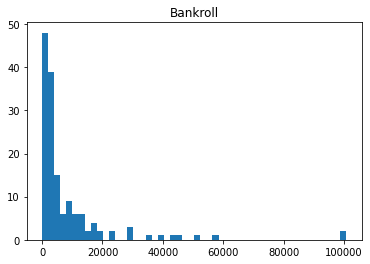

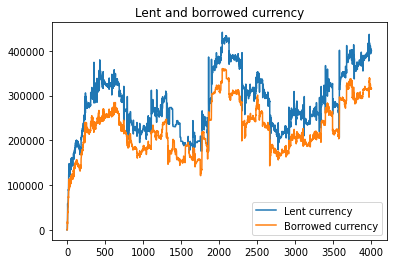

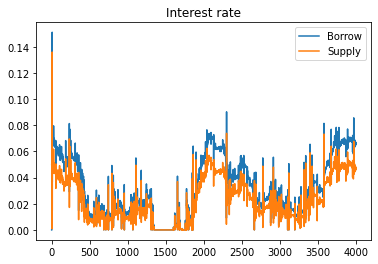

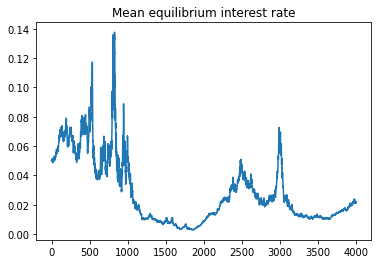

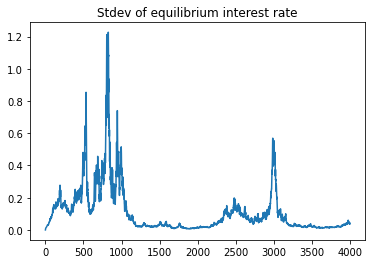

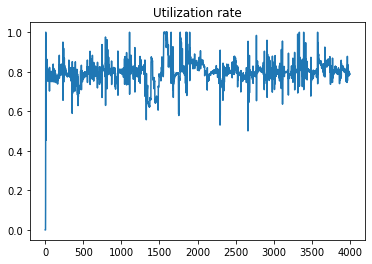

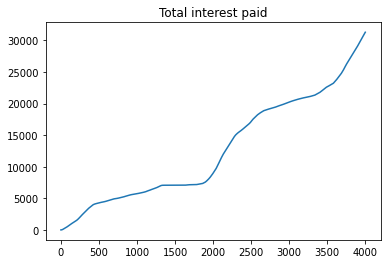

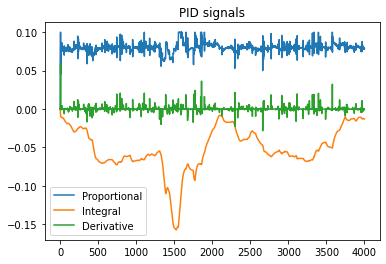

In [1447]:
interest_rate_model_in_use = 'pid'

block_number = 0

lent_currency = 0
borrowed_currency = 0

pid_derivative_signal = 0
pid_integral_accumulator = 0
pid_last_evaluated_block = 0
pid_last_evaluated_utilization_rate = 0

agents = []

for i in range(NUM_COMMERCIAL_TRADERS):
  agents.append(CommercialTrader())

for i in range(NUM_NOISE_TRADERS):
  agents.append(NoiseTrader())

plt.hist([agent.bankroll for agent in agents], bins=50)
plt.title('Bankroll')
plt.show()

lent_currency_history = []
borrowed_currency_history = []
borrow_interest_rate_history = []
supply_interest_rate_history = []
mean_equilibrium_interest_rate_history = []
stdev_equilibrium_interest_rate_history = []
utilization_rate_history = []
proportional_signal_history = []
integral_signal_history = []
derivative_signal_history = []
interest_paid_history = []
for i in range(int(BLOCKS_PER_YEAR * SIMULATION_LENGTH_YEARS)):
  block_number += 1
  lent_currency_history.append(lent_currency)
  borrowed_currency_history.append(borrowed_currency)
  borrow_interest_rate_history.append(get_borrow_interest_rate())
  supply_interest_rate_history.append(get_supply_interest_rate())
  mean_equilibrium_interest_rate_history.append(np.mean([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  stdev_equilibrium_interest_rate_history.append(np.std([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  utilization_rate_history.append(get_utilization_rate())
  proportional_signal_history.append(get_proportional_signal_pid_irm())
  integral_signal_history.append(pid_integral_accumulator * PID_IRM_INTEGRAL_GAIN)
  derivative_signal_history.append(pid_derivative_signal)
  interest_paid_history.append(borrowed_currency * get_borrow_interest_rate() / BLOCKS_PER_YEAR)

  for agent in agents:
    agent.step()

plt.plot(lent_currency_history, label='Lent currency')
plt.plot(borrowed_currency_history, label='Borrowed currency')
plt.title('Lent and borrowed currency')
plt.legend()
plt.show()

plt.plot(borrow_interest_rate_history, label='Borrow')
plt.plot(supply_interest_rate_history, label='Supply')
plt.title('Interest rate')
plt.legend()
plt.show()

plt.plot(mean_equilibrium_interest_rate_history)
plt.title('Mean equilibrium interest rate')
plt.show()

plt.plot(stdev_equilibrium_interest_rate_history)
plt.title('Stdev of equilibrium interest rate')
plt.show()

plt.plot(utilization_rate_history)
plt.title('Utilization rate')
plt.show()

plt.plot(np.cumsum(interest_paid_history))
plt.title('Total interest paid')
plt.show()

plt.plot(proportional_signal_history, label='Proportional')
plt.plot(integral_signal_history, label='Integral')
plt.plot(derivative_signal_history, label='Derivative')
plt.title('PID signals')
plt.legend()
plt.show()

The biggest advantage of a PID-based model is that it allows for low interest rates without needing a correspondingly low utilization rate. Since the utilization rate stays high, the spread between borrowing and lending interest rates is minimized. A small interest rate spread is important for minimizing deadweight loss. As long as you assume some proportion of traders who will only lend above a certain interest rate and borrow below a certain interest rate, the wider the spread is, the more likely such a trader will be unmotivated to take a position and interact with the market.

Another advantage of such a model is that it simplifies the governance and rate-setting process. Incentives, such as the recent addition of COMP emissions to the Compound protocol, can distort markets and make the process of choosing interest rate bounds more complex. For example, a yield-farming protocol might make it more interesting to borrow a stablecoin than it otherwise might have been. Instead of constantly updating the bounds of an interest rate model in response to DeFi trends, governance updates can be limited to making adjustments to the parameters of the PID controller in response to observed volatility.